In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 1500 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 1500 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":1500, 'savefig.dpi':1500}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [3]:
df = pd.read_csv('../RR_2m_Quan_multi.csv')
df['FID_RiverRd_AOI'] = np.where(df['NWI']=='wetland', 1, 0)
df['NWI'] = np.where(df['NWI']=='wetland', 'wetland', 'nonwetland')

# Fast Template for LightGBM

In [4]:
# Models takes in X for co-variates, y for outcome. gridid is a series with all the gridids
def LGB(X, y, gridid):
    # acc_score holds accuracy of all cross-validation iterations. Used to compute mean accuracy
    acc_score = [];
    # contains all truth values for each grid
    Truth = [];
    # contains all output values for each grid
    Output = [];
    # dataframe of grid ids(same as gridid that's passed in)
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])
    # 5 fold Cross-validation
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    
    # tqdm tracks how many iterations are done(useful for calculating how long processing will take) but not used for anything else
    # train_index and test_index are the indexes of the splits within the cross validation
    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        # X_train and X_test are the values within the dataframe for the train and test indexes
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        # similar to X_train and y_train
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        # Get the grid id of the grid at the train index
        train_grid = gridid.iloc[train_index]
        # get the grid id of the grid at the test index 
        test_grid= gridid.iloc[test_index]
        
        # Assign a model
        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
 
        # Fit the model to the train and predict the test
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        # Calculate the accuracy based on the predicted values
        acc = accuracy_score(y_test, pred_values)
        #Add the accuracy to the accuracy score array so we can take the average later
        acc_score.append(acc)
        
        # add the new grid(test_grid) to the data frame of gir ids
        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        # add the truth values we calculated to the truth array with data from all cross validations
        #i'm not sure about the exact reason why we reshape the array though :/
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        ## add the output values, same way as above
        Output.extend(pred_values);
    
    ## calculate mean accuracy
    accuracy = np.mean(acc_score)
    ## Combine grid id, truth, and output so it can be returned
    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    ## Calculate confusion matrix
    conf_mat = confusion_matrix(Truth, Output)
    ## Classification report
    class_rep = classification_report(Truth, Output, digits=4)
    ## Return outputs
    return output_df, accuracy, conf_mat, class_rep

# Comprehensive Template for LightGBM

In [5]:
def LGBM(X, y, gridid):
    fig, ax = plt.subplots()
    tree_axs = []
    
    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    feature_importances = pd.DataFrame()
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        t_ax = lgb.plot_tree(model, orientation='horizontal')
        tree_axs.append(t_ax)
        
        feature_importance = model.feature_importances_
        rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[i])
        feature_importances = pd.concat([feature_importances, rel_imp], axis=1)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Light Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
    feature_importances['mean'] = feature_importances.iloc[:, 0:5].mean(axis=1)

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt, feature_importances['mean'], tree_axs

# Testing LGBM

## 98(All) Covariates

5it [00:30,  6.01s/it]


30.080215000000003 seconds
[0.9493290143452106, 0.9488662656177695, 0.950948634891254, 0.9447015270708006, 0.9433001619995371]
0.9474291207849145 accuracy
[[ 6613   740]
 [  396 13860]]
              precision    recall  f1-score   support

           0     0.9435    0.8994    0.9209      7353
           1     0.9493    0.9722    0.9606     14256

    accuracy                         0.9474     21609
   macro avg     0.9464    0.9358    0.9408     21609
weighted avg     0.9473    0.9474    0.9471     21609

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


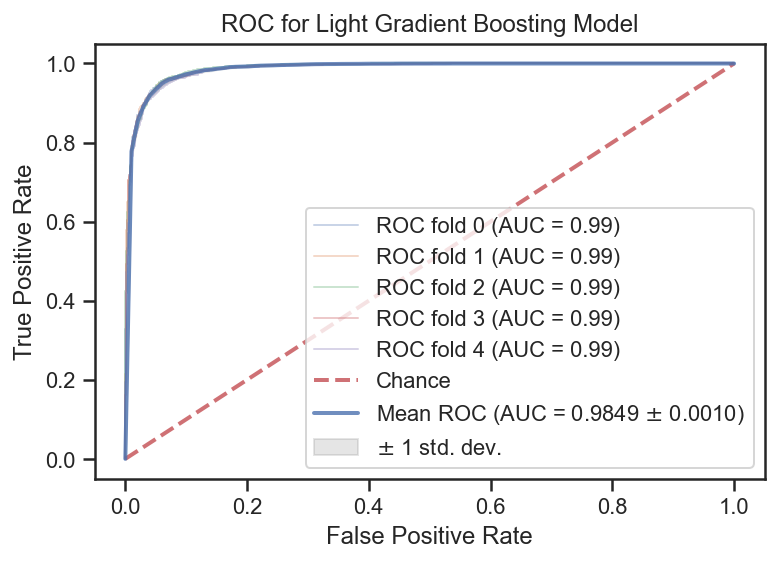

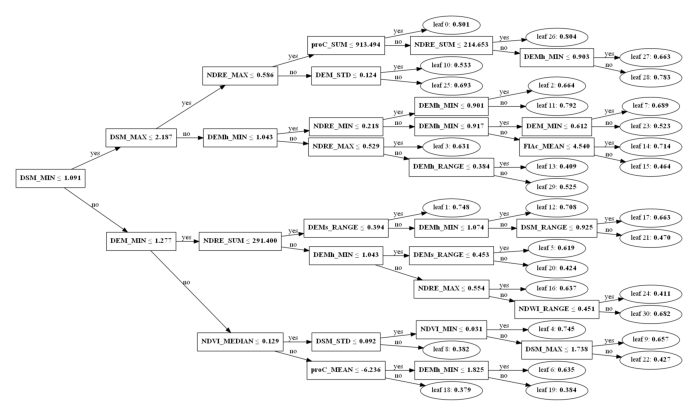

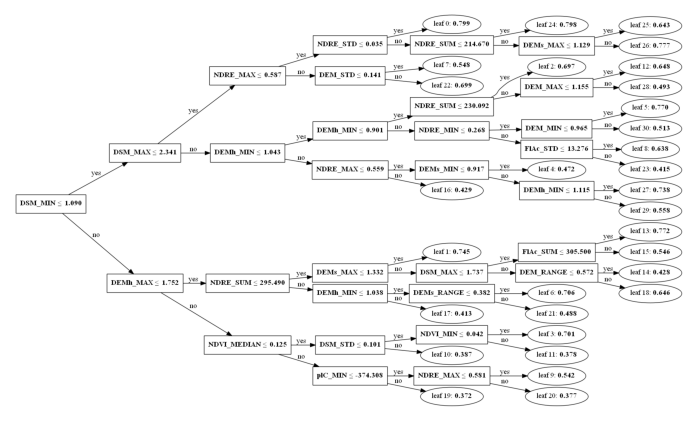

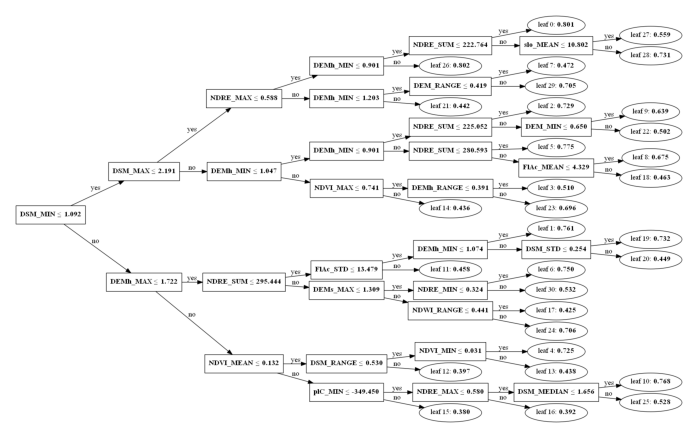

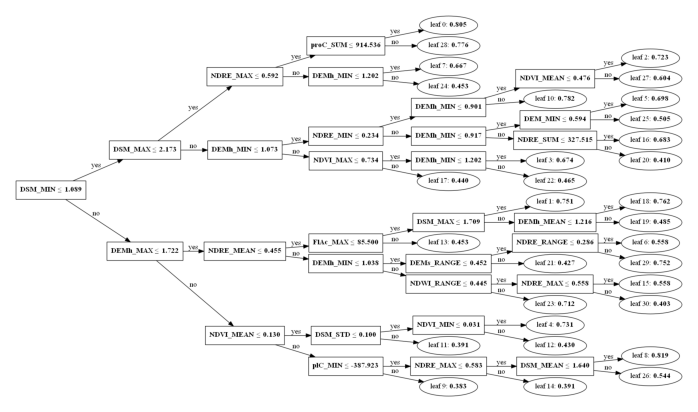

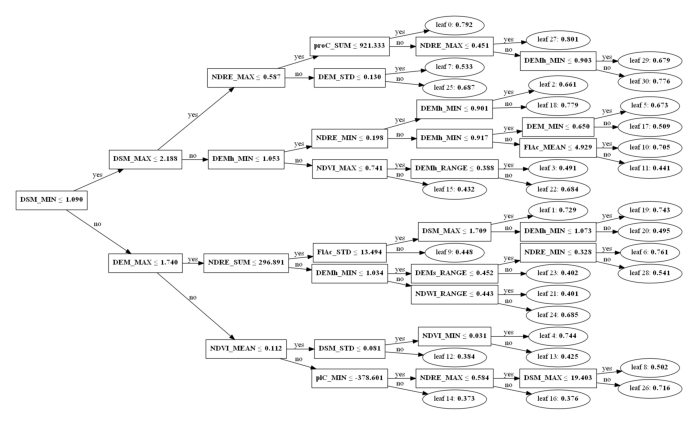

In [6]:
X = df.drop(['GRID_ID', 'NWI', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_98, time_98, cm_98, cr_98, acc_98, roc_98, feat_imp_98, tree_axs_98 = LGBM(X, y, gridid)
print(f"{time_98} seconds")
print(f"{acc_98}")
print(f"{np.mean(acc_98)} accuracy")
print(cm_98)
print(cr_98)
print(roc_98)

Text(0.5, 1.0, 'Variable Importance')

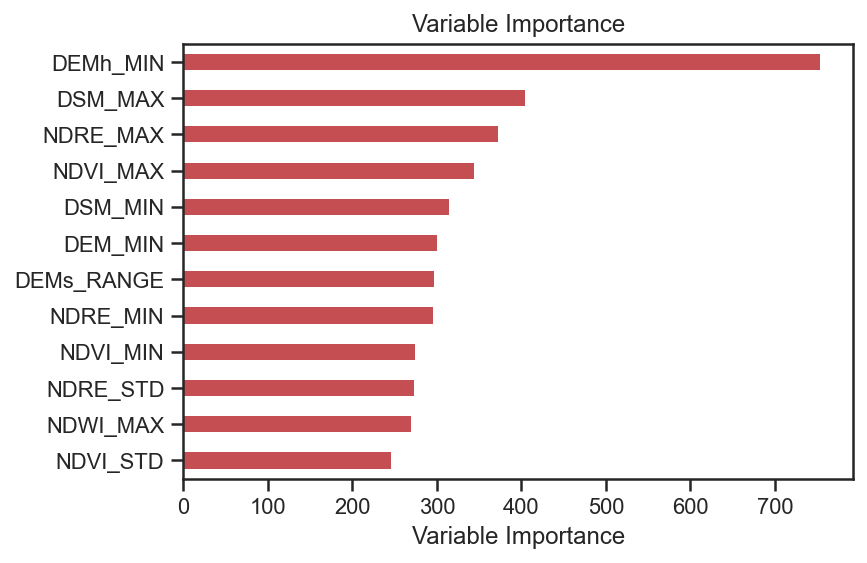

In [13]:
fig = feat_imp_98.sort_values()[-12:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance")

In [12]:
output_df_98.to_csv("../Comparison Data/LGBM98.csv", index=False)